# Stream

## Model Description 
This constructs a 2D steady state box model with a single stream reach
#### Dimensions: 
- 51 by 51 by 1 (note the odd number so that the stream can be centered)
- dx = dy = 100 m
- dz = 10 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x, y and z.
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Stream Properties: 
- Inflow to first reach = 0 m3/d
- Streambed slope = 0.0001 m/m
- Streambed rough = 0.02377
- Streambed width = 20 m
- Streambed K = 0.01 m/day for the rows 0-19, 0.1 for rows 20-25, and 1 for the rest of the stream. 
- Streambed thickness = 1 m
- Stream bottom depth = 7 m

#### Boundary Conditions: 
 - Right boundary is defined head representing a stream that runs 'down' the domain - in the direction of increasing row number.
 - Left boundary is a constant head representing a lake.

# Set up the environment

In [1]:
import flopy
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import flopy.utils.binaryfile as bf

%matplotlib inline

# User inputs

In [2]:
modelname = "str_model"
moddir="../../mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

nlay = 1
nrow = 51
ncol = 51
dx = 10
dy = 10
ztop = 10
zbot = 0.

dz = (ztop - zbot) / nlay
Lx = dx*ncol
Ly = dy*nrow

nper = 1
steady = [True]

# Setup the MODFLOW Packages other than the stream package

In [3]:
#Create dis object
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)


#Create bas object
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1

strt = np.ones((nlay, nrow, ncol), dtype=np.float32)  
strt[:, 0:51, 0] = 9                 #create strt as array of floats 
strt[:, 0:51, -1] = np.linspace(10,3,51)                 #create strt as array of floats 

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=2000, relax = 0.7, damp = 0.7)

#LPF object
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)      #defining conductivity in m/d
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

# vk = vk/10
# hk[:,0:25,:] = hk[:,0:25,:]*10
# vk = vk*10

ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage
ss[:,:,:] = 1e-5
n = 0.35
Sy = 0.3
uncnf = 1

lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=hk, 
                               vka=vk, ss=ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

# Rch object
recharge = 5e-3 #m/day
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone[0:26,:]=rech_zone[0:26,:]+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object

#create  output control object 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_15084\9500268.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss = np.ones((nlay,nrow,ncol), dtype=np.float)        #define specific storage


# Setup the stream! Define STR object

In [4]:
# User inputs:
k_strbott = 1                      #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
str_bott = 7                       #river bottom
slope = 0.0001                        #slope of streambed (m/m)
rough = 0.02377                         #roughness of streambed
width = 20.                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day (no water inn in our top of our domain)
Stage_above_datum = 9 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 1                   #1 if the stage is to be calculated based on flow, otherwise specify below
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

# calculated values for streambed conductance
cond = k_strbott*(dy)*(dx)/(sed_thick) #river bed conductance in f^2/d
cond_vals = np.ones(nrow)
cond_vals[0:20] = cond/100
cond_vals[21:26] = cond/10
cond_vals[27:-1] = cond

str_top = str_bott+sed_thick
str_stage = Stage_above_datum

if set_icalc > 0:      #Calculating the stage for graphing using Manning formula
    str_stage = str_top + ((Flow_into_the_1st_reach*rough)/(const*width*(slope**0.5)))**0.6   
    print("Calculated stage at inflow =", str_stage)

#Adding str package with only 1 stress period and one segment
strd = {}  
strspd = []
for x in range(nrow): #layer, row, column: layer=0, row=x, column=nrow/2, 1 is the segment. x+1 is the reach (they have to order from upstream to downstream)
    add = [0, x, ncol/2, 1, x+1, Flow_into_the_1st_reach, str_stage, cond_vals[x], str_bott, str_top, width, slope, rough]
    strspd.append(add)
strd[0]=strspd   
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=75, nss=1, ntrib=0, ndiv=0,icalc= set_icalc, const=const, ipakcb=53,  istcb2=istcb2, dtype=None,
        stress_period_data=strd, segment_data=str_segd, extension='str') 

Calculated stage at inflow = 8.0


# Plot model grid and boundary conditions

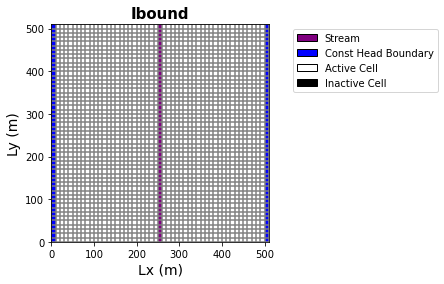

In [5]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

# Write MODFLOW input files and run the model

In [6]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: str_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 12:55:21

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/19 12:55:22
 Elapsed run time:  0.104 Seconds

  Normal termination of simulation


# Plot stream related results 

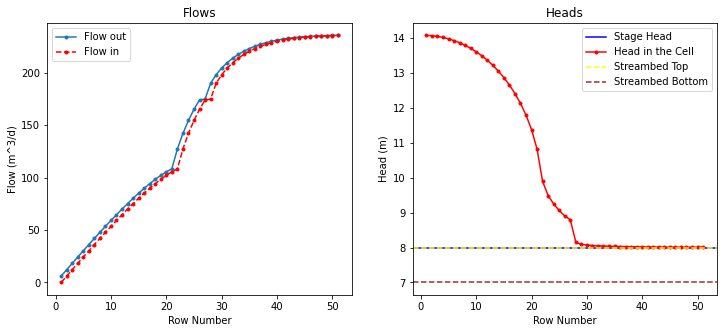

In [7]:
#####################################################################
# Reading budget and head output files
budgobj1 = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
frf = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
leak = budgobj1.get_data(text='STREAM LEAKAGE', totim=1.0) 

str_outflow = budgobj1.get_data(text='STREAM FLOW OUT', totim=1.0) 
ch_flow = budgobj1.get_data(text='CONSTANT HEAD', totim=1.0) 

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

#####################################################################
#Preparing variables for plotting 
leakage = leak[0]
str_outflow = str_outflow[0]
str_inflow = str_outflow[:nrow-1]
str_inflow = str_inflow['q']
str_inflow = str_inflow.tolist()
str_inflow.insert(0, Flow_into_the_1st_reach) 
reach = np.arange(0,nrow,1) + 1
head_reach=[]
x_str = strspd[0][2]
x_str=int(x_str)
for i in range(nrow):
    head_reach.append(head[0][i][x_str])

#####################################################################
# Plotting reach wise water budget
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#ax.set_aspect('equal')
ax1.set_title('Flows')
# ax1.plot(reach, leakage['q'], lw=3, label="Leaked to Aquifer", marker='o') 
ax1.plot(reach, str_outflow['q'], label="Flow out", marker='.') 
ax1.plot(reach, str_inflow, color='red', label="Flow in", linestyle='--', marker='.') 
# ax1.axhline(y=0,  color='black', linestyle='--')
ax1.set_xlabel('Row Number')
#ax1.set_xticks(reach)
ax1.set_ylabel('Flow (m^3/d)')
ax1.legend()

#####################################################################
# Plotting reach wise heads
ax2.set_title('Heads')
ax2.axhline(y=str_stage,  color='blue', label="Stage Head")
ax2.plot(reach, head_reach, color='red', label="Head in the Cell", marker='.') 
ax2.axhline(y=str_top,  color='yellow', linestyle='--', label="Streambed Top")
ax2.axhline(y=str_bott,  color='brown', linestyle='--', label="Streambed Bottom")
ax2.set_xlabel('Row Number')
#ax2.set_xticks(reach)
ax2.set_ylabel('Head (m)')
ax2.legend()

# Plot head distribution

C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\ual-laptop\miniconda3\envs\gwmod38\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


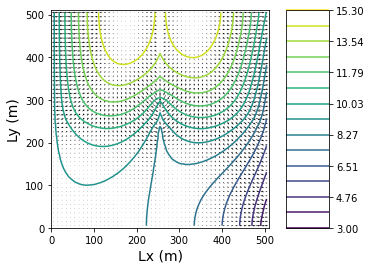

In [8]:
#####################################################################
# Plotting heads and flow arrows
plt.figure() 
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
#plt.title('Steady-State Pumping, Flow(f^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)

In [9]:
#Setup the stream characteristics 
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0 # m^3/day
head_str = 0.5 #meters above the bed
set_icalc = 0  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 
#Calculate the streambed conductance 
k_strbott = 1.36 * K_horiz  #river bottom hydraulic conductivity in l/t
sed_thick = 1 #thickness of riverbed sediment 
cond = k_strbott*(width)*(dy)/(sed_thick)

#Setup the reach locations stream segment numbers and reach numbers
#(Note we are taking a slightly more complicated approach here setting the streambed relative to the elevation of the land surface)
#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 25    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well
nseg = np.max(segments) #NOTE: check if this is ok

#Setup the inflows for the reaches
Qreturn =50     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

#Setup the elevation of the streams
#(In this case we will be setting it relative to surface elevation which is an array called ‘ztop’)
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + head_str      # elevation of the water surface in the stream (m)

#Setup the stress period dictionary
str_info = np.zeros((nreach,12)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary


#Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=nreach, nss=1, ntrib=2, ndiv=0, icalc=set_icalc, const=const, ipakcb=53,
                                      istcb2=53, dtype=None, segment_data=str_segd, extension='str')


NameError: name 'K_horiz' is not defined